In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostClassifier
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import re


# Load dataset
file_path = "rotten_tomatoes_critic_reviews.csv"
# For fast test
# file_path = "sampled_data.csv"
data = pd.read_csv(file_path)





In [2]:
# Normalize Review Scores to 0-10
def normalize_review_score(score):
    score = str(score).strip()

    # Handle x/y format
    if "/" in score:
        try:
            num, denom = map(float, score.split("/"))
            if denom == 0:
                return np.nan
            return (num / denom) * 10
        except:
            return np.nan

    # Letter grade to number
    letter_grades = {
        "A+": 10, "A": 9, "A-": 8.5,
        "B+": 8, "B": 7, "B-": 6.5,
        "C+": 6, "C": 5, "C-": 4.5,
        "D+": 4, "D": 3, "D-": 2.5,
        "F": 0
    }
    if score.upper() in letter_grades:
        return letter_grades[score.upper()]

    # Digital direct convert
    try:
        val = float(score)
        if val > 50:       # Assume percentage out of 100
            return val / 10
        elif val > 10:     # Assume out of 20
            return val / 20 * 10
        return val
    except:
        return np.nan


# Step 1: Sampling
data = data.sample(frac=0.4, random_state=42).reset_index(drop=True)
# Step 2: Clean fields
data = data.dropna(subset=["review_content", "review_type", "top_critic"])
data = data[data["review_score"].notna() & (data["review_score"] != "")]

# Step 3: Normalize fields
data["sentiment"] = data["review_type"].map({"Fresh": 1, "Rotten": 0})
data["is_critic"] = data["top_critic"].astype(str).str.lower().map({"true": 1, "false": 0})
data["normalized_score"] = pd.to_numeric(data["review_score"].apply(normalize_review_score), errors="coerce")
data = data[data["normalized_score"].between(0, 10)]

# Step 4: Remove sentiment-score conflicts
pos_conflict = (data["sentiment"] == 1) & (data["normalized_score"] < 4)
neg_conflict = (data["sentiment"] == 0) & (data["normalized_score"] > 6)
conflicts = pos_conflict | neg_conflict
data_cleaned = data[~conflicts].copy()

# Verify Data
print(data[["review_content", "sentiment", "normalized_score", "is_critic"]].head())


                                      review_content  sentiment  \
0  Smurftastically stupid. Here's a sequel to a m...          0   
1  ...recognizes that it's okay to present scarin...          1   
3  The lead actors are basically unknown to Ameri...          1   
4  There's no tension as to where things are goin...          0   
5  A soft-centred piece of movie confectionery, n...          1   

   normalized_score  is_critic  
0              4.00          0  
1              8.00          0  
3              6.00          0  
4              6.25          0  
5              6.00          1  


In [3]:
# Convert text data into TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words="english")
X_text = vectorizer.fit_transform(data["review_content"])


In [4]:

# Define target variable (sentiment)
y_sentiment = data["sentiment"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_text, y_sentiment, test_size=0.2, random_state=42)

# Train logistic regression classifier
sentiment_model = LogisticRegression()
sentiment_model.fit(X_train, y_train)

# Predict
y_pred = sentiment_model.predict(X_test)

# Evaluate model
print(f"TF-IDF Sentiment Analysis Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


TF-IDF Sentiment Analysis Accuracy: 0.80
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.64      0.70     21939
           1       0.81      0.89      0.85     38652

    accuracy                           0.80     60591
   macro avg       0.79      0.77      0.78     60591
weighted avg       0.80      0.80      0.80     60591



In [5]:
# Define target variable (critic)
y_critic = data["is_critic"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_text, y_critic, test_size=0.2, random_state=42)

# Train classifier
critic_model = LogisticRegression()
critic_model.fit(X_train, y_train)

# Predict probabilities
y_pred_prob = critic_model.predict(X_test)
y_pred_prob1 = critic_model.predict_proba(X_test)[:1]
# Evaluate
print(f"TF-IDF Critic Probability Model Accuracy: {accuracy_score(y_test, y_pred_prob):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_prob))

TF-IDF Critic Probability Model Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.98      0.86     46288
           1       0.48      0.05      0.09     14303

    accuracy                           0.76     60591
   macro avg       0.63      0.52      0.47     60591
weighted avg       0.70      0.76      0.68     60591



In [6]:
data_sample = data.sample(frac=0.4, random_state=42)

X_sample = vectorizer.fit_transform(data_sample["review_content"])
y_sample = data_sample["normalized_score"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Train Random Forest (Works with sparse input)
score_model = RandomForestRegressor(n_estimators=50, n_jobs=-1)
score_model.fit(X_train, y_train)

# Predict
y_pred = score_model.predict(X_test)

# Evaluate
print(f"Mean Squared Error for Score Prediction: {mean_squared_error(y_test, y_pred):.2f}")

Mean Squared Error for Score Prediction: 3.29


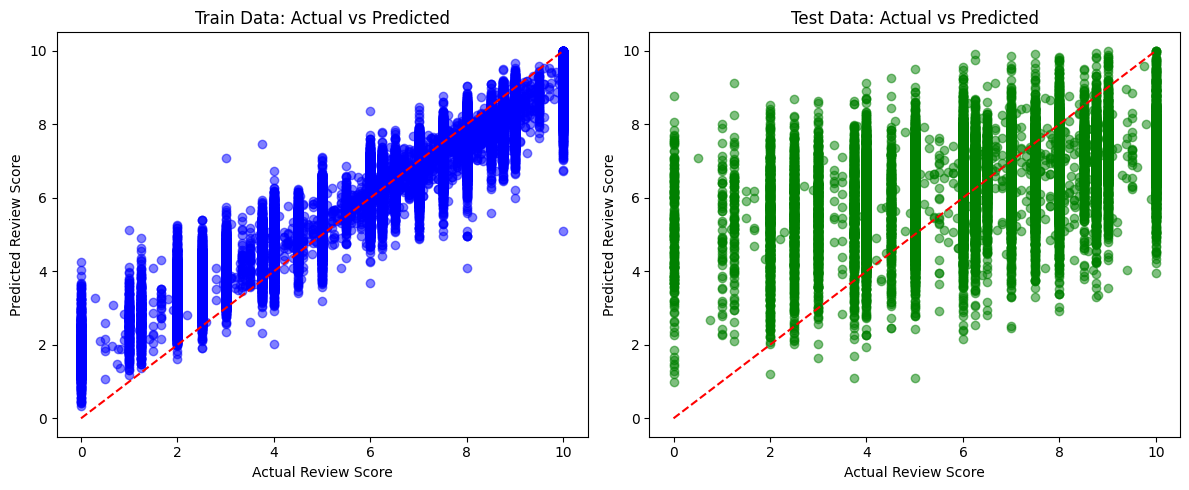

In [7]:


# Predict on Train and Test Data
y_train_pred = score_model.predict(X_train)
y_test_pred = score_model.predict(X_test)

plt.figure(figsize=(12, 5))

# Train Data
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')  # Perfect fit line
plt.xlabel("Actual Review Score")
plt.ylabel("Predicted Review Score")
plt.title("Train Data: Actual vs Predicted")

# Test Data
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect fit line
plt.xlabel("Actual Review Score")
plt.ylabel("Predicted Review Score")
plt.title("Test Data: Actual vs Predicted")

plt.tight_layout()
plt.show()

